# TP OpenMP - December 2025 réalisé par Danial HABIB et Maroun CHAHINE
## Part 1 : Pi
### Compilation

In [1]:
!g++ -o ./exe_bin/tp_openmp_part_1_pi_sequential ./Part_1/tp_openmp_part_1_pi_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_reduce ./Part_1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_atomic ./Part_1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_critical ./Part_1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_split_array ./Part_1/tp_openmp_part_1_pi_impl_split_array.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [2]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

num_steps = [1000, 1000000]#, 100000000, 10000000000, 1000000000000]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,10)
executables = ['tp_openmp_part_1_pi_sequential', 'tp_openmp_part_1_pi_impl_reduce', 'tp_openmp_part_1_pi_impl_atomic', 'tp_openmp_part_1_pi_impl_critical', 'tp_openmp_part_1_pi_impl_split_array']

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            for executable in executables:
                args = ("./exe_bin/" + executable, "-C", str(ncore), "-N", str(nsteps))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                try:
                    out, err = popen.communicate(timeout=1)
                except Exception:
                    out = b''
                if isinstance(out, bytes):
                    out = out.decode(errors='ignore')

                m = re.search(r'pi with\s+(\d+)\s+steps is\s+([0-9.+-eE]+)\s+in\s+([0-9.+-eE]+)\s+seconds', out)
                if m:
                    pi_val = m.group(2)
                    time_s = m.group(3)
                else:
                    # fallback: use last non-empty line of stdout
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    pi_val = ''
                    time_s = ''
                    # try to extract numbers from last line if possible
                    m2 = re.search(r'([0-9.+-eE]+).*in.*([0-9.+-eE]+)\s*seconds', last)
                    if m2:
                        pi_val = m2.group(1)
                        time_s = m2.group(2)

                # one-line summary
                # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                csv_path = './Part_1/stats.csv'
                with open(csv_path, 'a') as fh:
                    fh.write(f"{executable},{ncore},{nsteps},{time_s}\n")



### Performance analysis
#### Weak scaling

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


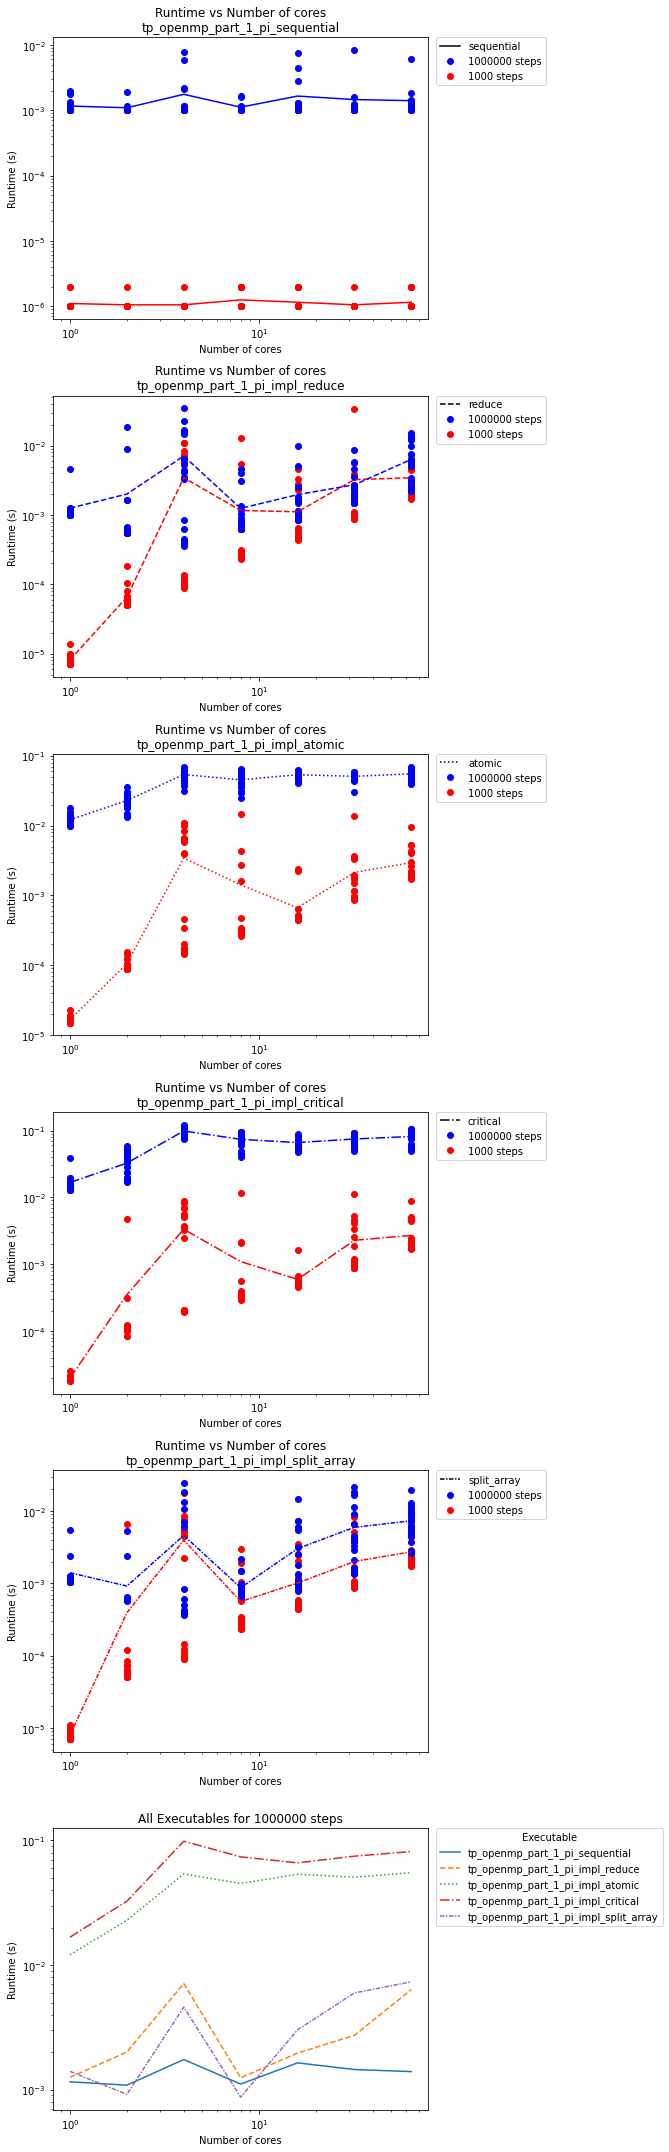

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Lecture du fichier CSV
df = pd.read_csv('./Part_1/stats.csv', header=None, names=['version','nbcore','num_steps','runtime'], dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {1000000 : "blue", 1000 : "red"}

# Nombre de subplots à créer : un pour chaque exécutable, cette fois disposés verticalement
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))

# Si il n'y a qu'un seul subplot (si executables ne contient qu'un seul élément)
if len(executables) == 1:
    axes = [axes]

# Style des lignes pour les différents exécutables
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]  # fallback styles pour jusqu'à 5 exécutables

# Tracer les courbes pour chaque exécutable dans son subplot respectif
for idx, executable in enumerate(executables):
    ax = axes[idx]  # Sélectionner le subplot correspondant à l'exécutable
    for num_steps in sorted(df['num_steps'].unique()):
        df_plot = df[(df['num_steps'] == int(num_steps)) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=color_num_steps[int(num_steps)])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=color_num_steps[int(num_steps)])

    # Définir l'échelle des axes et les labels pour chaque subplot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Ajouter des légendes spécifiques pour cet exécutable
    num_steps_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f'{n} steps')
        for n, color in color_num_steps.items()
    ]
    version_handles = [
        plt.Line2D([0], [0], linestyle=ls, color='black', label=executable.replace('tp_openmp_part_1_pi_impl_', '').replace('tp_openmp_part_1_pi_', ''))
    ]

    ax.legend(handles=version_handles + num_steps_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajouter un graphe avec tous les exécutables pour num_steps=1000000
ax_all_executables = axes[-1]  # Le dernier subplot

for executable in executables:
    df_plot = df[(df['num_steps'] == 1000000) & (df['version'] == executable)]
    if df_plot.empty:
        continue
    mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
    ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
    ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

# Définir l'échelle des axes et les labels pour le graphique global
ax_all_executables.set_xscale('log')
ax_all_executables.set_yscale('log')
ax_all_executables.set_xlabel('Number of cores')
ax_all_executables.set_ylabel('Runtime (s)')
ax_all_executables.set_title('All Executables for 1000000 steps')

# Ajouter une légende pour le graphique global
ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Ce programme permet de calculer π en utilisant une fonction dont l'intégrale vaut π. Le nombre de "steps" correspond au nombre de rectangles dont on calcule l'aire sous la courbe.

Il y a cinq types de programmes :
- Le séquentiel
- Quatre programmes parallèles utilisant quatre stratégies différentes de parallélisation :
    - Atomic : quand il y a une variable partagée entre plusieurs threads, par exemple une variable de somme. Quand deux threads essaient d'accéder en même temps à cette variable, OpenMP bloque l'un d'eux jusqu'à ce que l'autre ait terminé son travail. Cela bloque uniquement sur des opérations simples comme l'addition ou la soustraction.
    - Reduce : au lieu de bloquer, on crée une variable pour chaque thread et à la fin, on fait la somme des sommes.
    - Split_array : c'est la même implémentation que reduce, mais codée manuellement.
    - Critical : c'est la même logique que atomic, sauf que c'est défini sur un bloc de code quelconque, qui peut être plus ou moins complexe. Il est donc plus compliqué à gérer. Utiliser critical plutôt qu'atomic pour des blocs de code simples peut réduire les performances.

Dans le dernier graphique, on peut voir que le temps d'exécution le plus long correspond au programme utilisant critical, car les coûts de synchronisation sont les plus importants. En effet, cela bloque tous les autres threads tant qu'un thread est en train d'exécuter le bloc de code marqué critical. Ensuite, on observe que atomic utilise la même logique de blocage, mais uniquement pour des opérations arithmétiques simples, ce qui le rend plus performant que critical.

Ensuite, on constate que reduce et split_array sont beaucoup plus performants, et leur comportement est très similaire. En effet, les deux méthodes suivent la même logique : OpenMP pour reduce, et une implémentation manuelle pour split_array. Ces deux stratégies sont plus performantes car elles ne bloquent pas les threads. Au contraire, elles calculent réellement en parallèle en utilisant des variables de somme partielles, et à la fin, on fait la somme de toutes les sommes.

Le programme séquentiel prend moins de temps d'exécution que les autres programmes parallèles. Cela peut s'expliquer par le fait que les coûts de synchronisation sont parfois si élevés que paralléliser devient plus coûteux que d'exécuter le programme de manière séquentielle.

Dans le premier graphique, on remarque que le temps reste constant pour le programme séquentiel lorsqu'on change le nombre de cœurs. Cela vient du fait que le programme séquentiel utilise toujours un seul cœur. On voit aussi que plus on augmente le nombre de "steps", plus cela prend du temps, ce qui est logique car il y a plus de calculs à effectuer.

Pour les autres graphiques (les programmes parallèles), les courbes ont la même forme. On voit que plus on augmente le nombre de cœurs, plus le temps d'exécution augmente. Cela vient du coût de synchronisation, qui devient de plus en plus important, ce qui fait perdre l'intérêt du parallélisme. Cependant, on remarque qu'à un certain moment, le temps d'exécution diminue. Cela est dû au fait que le parallélisme augmente les performances : en divisant les calculs sur plusieurs cœurs, chacun effectue moins de calculs, ce qui permet de gagner du temps. De plus, le coût de synchronisation n'est pas encore trop élevé, donc le parallélisme dans ce cas améliore effectivement les performances.

## Part 2 : Matrix-Vector Operation
### Compilation


In [4]:
!g++ -o ./exe_bin/tp_openmp_part_2_vector_openmp ./Part_2/tp_openmp_part_2_vector_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_2_vector_sequential ./Part_2/tp_openmp_part_2_vector_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_2_vector_simd ./Part_2/tp_openmp_part_2_vector_simd.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [5]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [2, 4]#, 8, 10, 12, 14, 16]
M = [1, 3]#, 7, 9, 11, 13, 15]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,20)
executables = ['tp_openmp_part_2_vector_openmp', 'tp_openmp_part_2_vector_sequential', 'tp_openmp_part_2_vector_simd']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_2/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



### Performance analysis
#### Weak scaling

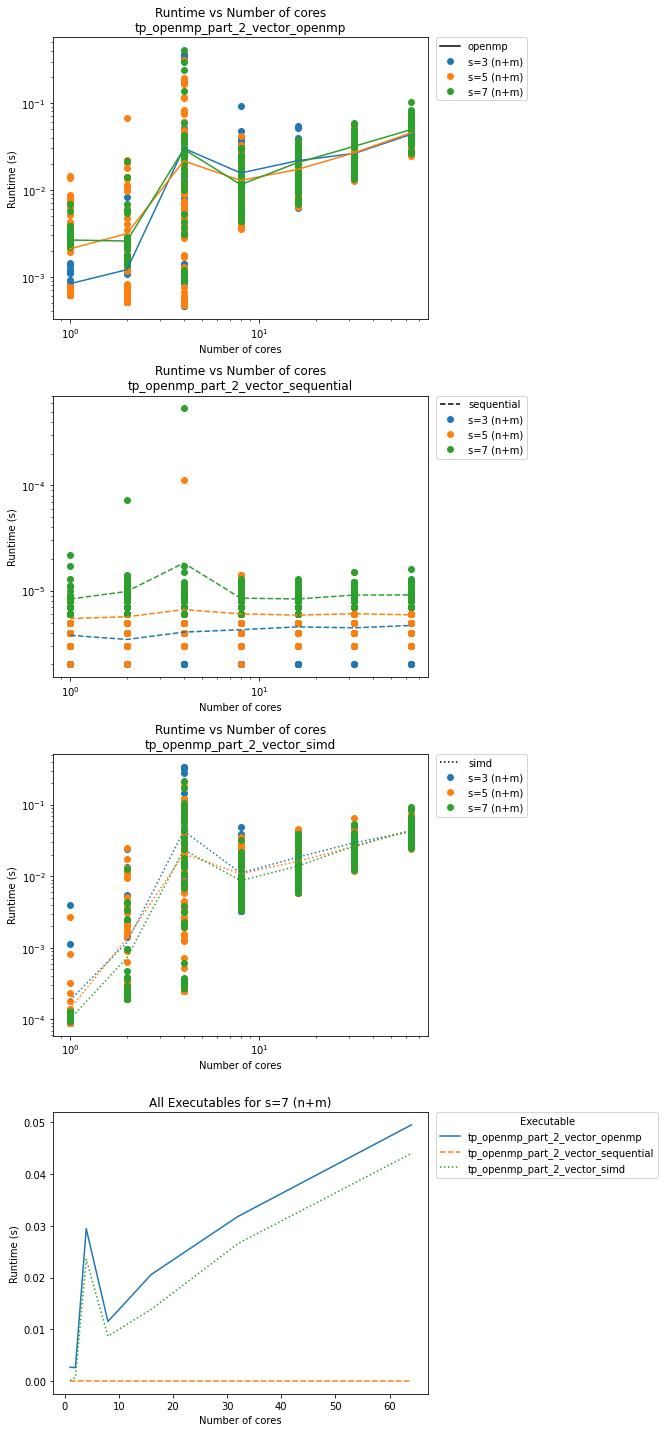

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Lecture du fichier CSV Part 2 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_2/stats.csv', header=None,
                 names=['version','nbcore','n','m','runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

# nouvelle colonne s = n + m
df['s'] = df['n'] + df['m']

# mapping de couleurs pour chaque valeur de s
unique_s = sorted(df['s'].unique())
cmap = plt.get_cmap('tab10')
colors_s = {s: cmap(i % cmap.N) for i, s in enumerate(unique_s)}

# subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

for idx, executable in enumerate(executables):
    ax = axes[idx]
    for s in unique_s:
        df_plot = df[(df['s'] == s) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_s[s])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_s[s])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # légende par valeur de s
    s_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_s[s], markersize=8, label=f's={s} (n+m)')
        for s in unique_s
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_openmp_part_2_vector_', ''))
    ax.legend(handles=[version_handle] + s_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# dernier subplot : tracer tous les exécutables pour une valeur de s choisie (ici la plus grande s)
ax_all_executables = axes[-1]
s_to_plot = unique_s[-1] if unique_s else None

if s_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['s'] == s_to_plot) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    #ax_all_executables.set_xscale('log')
    #ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for s={s_to_plot} (n+m)')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Dans ce programme, on effectue le calcul d'un produit scalaire de vecteurs. S, N et M représentent la taille des matrices et des vecteurs sur lesquels on fait les calculs.

Il y a trois programmes : un séquentiel, un utilisant le calcul parallèle, et un utilisant la technique SIMD (Single Instruction Multiple Data) en essayant d'aligner les cases mémoire pour effectuer plusieurs calculs en une seule instruction.

À partir du dernier graphe, on remarque une observation inattendue : le programme séquentiel prend moins de temps d'exécution que le SIMD et le programme parallèle. Cela peut venir du fait qu'il y a des coûts de synchronisation, et que parfois, le coût de synchronisation est tellement élevé que le fait de paralléliser devient très coûteux, ce qui fait perdre l'intérêt de la parallélisation. Dans ce cas, rester sur le séquentiel peut être plus avantageux. En comparant le SIMD avec le programme parallèle, on observe que c'est à peu près pareil, sauf que le SIMD est plus rapide.

Dans le deuxième graphe, on remarque que le temps reste constant pour le programme séquentiel lorsqu'on change le nombre de cœurs. Cela vient du fait que le programme séquentiel utilise toujours un seul cœur. On voit aussi que plus la taille des vecteurs augmente, plus cela prend du temps, ce qui est logique car il y a plus de calculs à effectuer.

Pour les deux autres graphes (SIMD et parallèle OpenMP), les courbes ont la même forme. On voit que plus on augmente le nombre de cœurs, plus le temps d'exécution augmente. Cela vient du coût de synchronisation qui devient de plus en plus important, ce qui fait perdre l'intérêt de paralléliser. Cependant, on remarque qu'à un certain moment, le temps d'exécution diminue. Cela est dû au fait que le parallélisme augmente les performances : en divisant le calcul sur plusieurs cœurs, chacun effectue moins de calculs, ce qui permet de gagner du temps. De plus, le coût de synchronisation n'est pas encore trop élevé, donc le parallélisme dans ce cas améliore effectivement les performances.

## Part 3 : Fibonacci and linked lists
### Compilation

In [7]:
!g++ -o ./exe_bin/tp_openmp_part_3_fib_openmp ./Part_3/tp_openmp_part_3_fib_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_3_fib_sequential ./Part_3/tp_openmp_part_3_fib_sequential.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [8]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [3, 5]#, 15, 20, 25, 30, 35, 40]
nb_core = [1, 2, 4, 8]#, 16, 32, 64]
repeats = range(0,10)
executables = ['tp_openmp_part_3_fib_openmp', 'tp_openmp_part_3_fib_sequential']

for n in N:
    for ncore in nb_core:
        for repeat in repeats:
            for executable in executables:
                args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                try:
                    out, err = popen.communicate(timeout=1)
                except Exception:
                    out = b''
                if isinstance(out, bytes):
                    out = out.decode(errors='ignore')

                # extraire uniquement le temps (en secondes) depuis la sortie
                lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                last = lines[-1] if lines else ''
                time_s = ''

                # priorité 1: "Compute Time: 0.123456 seconds" présent dans la sortie
                m_time = re.search(r'Compute\s+Time:\s*([0-9.+-eE]+)\s*seconds', out, flags=re.IGNORECASE)
                if m_time:
                    time_s = m_time.group(1)
                else:
                    # fallback 1: "in X seconds"
                    m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                    if m_time2:
                        time_s = m_time2.group(1)
                    else:
                        # fallback final: dernier nombre flottant sur la dernière ligne non vide
                        m3 = re.findall(r'([0-9.+-eE]+)', last)
                        time_s = m3[-1] if m3 else ''

                # one-line summary
                # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                csv_path = './Part_3/stats.csv'
                with open(csv_path, 'a') as fh:
                    fh.write(f"{executable},{ncore},{n},{time_s}\n")



### Performance analysis
#### Weak scaling

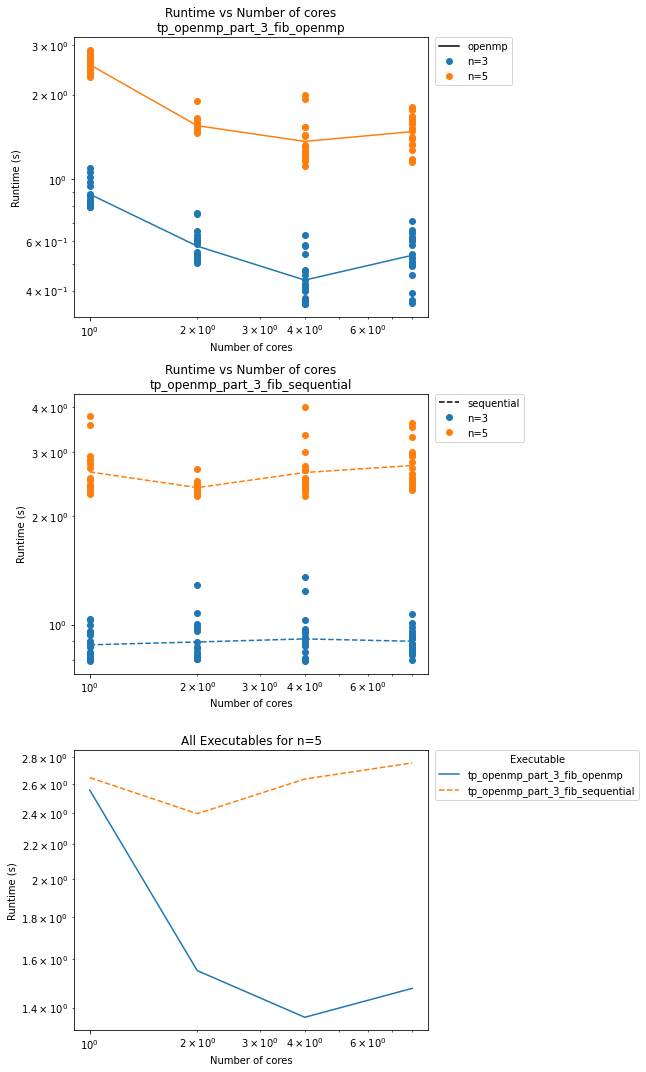

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lecture du fichier CSV Part 2 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_3/stats.csv', header=None,
                 names=['version', 'nbcore', 'n', 'runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'runtime': float})

# Mapping de couleurs pour chaque valeur de n (et non plus de s)
unique_n = sorted(df['n'].unique())  # utiliser 'n' à la place de 's'
cmap = plt.get_cmap('tab10')
colors_n = {n: cmap(i % cmap.N) for i, n in enumerate(unique_n)}

# Subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

for idx, executable in enumerate(executables):
    ax = axes[idx]
    for n in unique_n:  # Remplacer 's' par 'n' ici
        df_plot = df[(df['n'] == n) & (df['version'] == executable)]  # Filtrer par 'n' et 'executable'
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['n', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_n[n])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_n[n])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Légende par valeur de n
    n_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_n[n], markersize=8, label=f'n={n}')
        for n in unique_n
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_openmp_part_3_fib_', ''))
    ax.legend(handles=[version_handle] + n_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Dernier subplot : tracer tous les exécutables pour une valeur de n choisie (ici la plus grande n)
ax_all_executables = axes[-1]
n_to_plot = unique_n[-1] if unique_n else None

if n_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['n'] == n_to_plot) & (df['version'] == executable)]  # Filtrer par 'n' ici
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['n', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for n={n_to_plot}')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Le programme 'tp_openmp_part_3_fib_sequential' calcule le Fibonacci de n nombres, en commençant par 38 jusqu'à 38+n, de manière séquentielle. 'tp_openmp_part_3_fib_openmp' fait la même chose, mais en utilisant t cœurs en parallèle.

On observe dans le deuxième graphe, qui représente le programme séquentiel, que pour n=3, le temps d'exécution est plus court que pour n=5, ce qui est logique puisque l'on effectue moins de calculs. On remarque également qu'en augmentant le nombre de cœurs, le temps d'exécution reste le même, car c'est le programme séquentiel qui utilise toujours un seul cœur.

Dans le premier graphe, on voit que pour n=3, le temps d'exécution est plus court que pour n=5, car on effectue moins de calculs. Mais cette fois-ci, on remarque que plus le nombre de cœurs augmente, plus les tâches sont réparties sur plusieurs cœurs, ce qui réduit le temps d'exécution.

Le troisième graphe permet de comparer le programme séquentiel avec le programme parallèle. On y observe que, lorsque plusieurs cœurs sont utilisés, les performances sont meilleures.

## Part 4 : Matrix Multiplication
### Compilation

In [10]:
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp ./Part_4/tp_open_part_4_matrix_mult_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_sequential ./Part_4/tp_open_part_4_matrix_mult_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp_half ./Part_4/tp_open_part_4_matrix_mult_openmp_half.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp_float ./Part_4/tp_open_part_4_matrix_mult_openmp_float.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [11]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
M = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
nb_core = [1, 2, 4]#, 8, 16, 32, 64]
repeats = range(0,3)
executables = ['tp_open_part_4_matrix_mult_sequential', 'tp_open_part_4_matrix_mult_openmp', 'tp_open_part_4_matrix_mult_openmp_half', 'tp_open_part_4_matrix_mult_openmp_float']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_4/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



### Performance analysis
#### Weak scaling

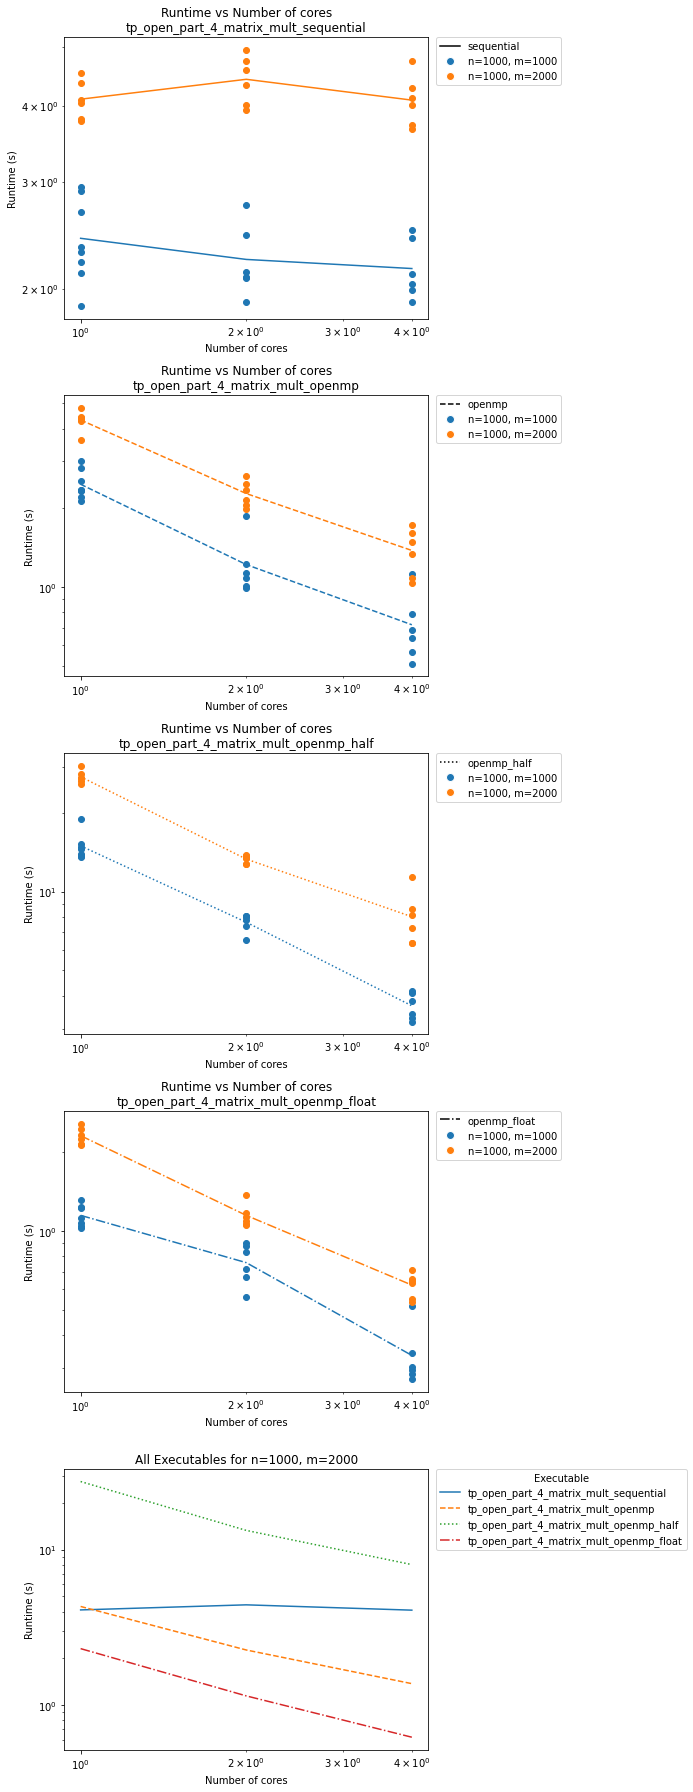

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lecture du fichier CSV Part 4 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_4/stats.csv', header=None,
                 names=['version', 'nbcore', 'n', 'm', 'runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

df.dropna(subset=['runtime'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Création de la colonne nm pour le couple (n, m)
df['nm'] = list(zip(df['n'], df['m']))

# Mapping de couleurs pour chaque couple (n, m)
unique_nm = sorted(df['nm'].unique())  # Utiliser (n, m) au lieu de 'n' seul
cmap = plt.get_cmap('tab10')
colors_nm = {nm: cmap(i % cmap.N) for i, nm in enumerate(unique_nm)}

# Subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

# Styles de ligne pour chaque exécutable
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

# Tracer chaque exécutable
for idx, executable in enumerate(executables):
    ax = axes[idx]
    for nm in unique_nm:  # Filtrer par couple (n, m)
        df_plot = df[(df['nm'] == nm) & (df['version'] == executable)]  # Filtrer par (n, m) et 'version'
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_nm[nm])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_nm[nm])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Légende par couple (n, m)
    nm_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_nm[nm], markersize=8, label=f'n={nm[0]}, m={nm[1]}')
        for nm in unique_nm
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_open_part_4_matrix_mult_', ''))
    ax.legend(handles=[version_handle] + nm_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Dernier subplot : tracer tous les exécutables pour un couple (n, m) choisi (ici le dernier couple (n, m))
ax_all_executables = axes[-1]
nm_to_plot = unique_nm[-1] if unique_nm else None

if nm_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['nm'] == nm_to_plot) & (df['version'] == executable)]  # Filtrer par (n, m)
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for n={nm_to_plot[0]}, m={nm_to_plot[1]}')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Dans ce programme, on effectue la multiplication entre A(N×P) et B(P×M) pour obtenir C(N×M). Dans ce programme Python, on exécute les programmes pour des valeurs de N et M différentes, avec P fixé à 1000.

Cette partie ressemble beaucoup à la partie 3 dans le sens où il y a un programme séquentiel et 3 autres programmes parallèles. Les deuxième, troisième et quatrième graphiques, qui représentent les 3 programmes parallèles, montrent que la multiplication de matrices plus grandes prend plus de temps que la multiplication de petites matrices. Le deuxième point important est que plus le nombre de cœurs augmente, moins le temps d'exécution est long, car les calculs sont répartis entre les cœurs.

On remarque que pour le premier graphique, le programme a un temps d'exécution plus important pour la multiplication de grandes matrices, mais le temps reste le même lorsqu'on change le nombre de cœurs. Cela est dû au fait que c'est un programme séquentiel, donc il utilise toujours un seul cœur.

Dans le dernier graphique, on peut identifier la différence entre les trois types de programmes parallèles :
- 'tp_open_part_4_matrix_mult_openmp' utilise le type double pour les coefficients de la matrice,
- 'tp_open_part_4_matrix_mult_openmp_half' utilise le half.cpp fourni sur Moodle,
- 'tp_open_part_4_matrix_mult_openmp_float' utilise le float.

Le graphique montre les résultats pour n=1000 et m=2000. On observe que le temps d'exécution avec le float est plus court qu'avec le double, ce qui est logique, car le float est codé sur 32 bits, alors que le double l'est sur 64 bits. Par conséquent, on effectue le calcul sur un nombre de bits moins important, ce qui améliore la performance, mais avec une perte de précision lorsque l'on utilise le float.

Le half prend plus de temps que le double, car il bénéficie de certaines optimisations matérielles, alors que le fichier half.cpp est un fichier implémenté en C++, ce qui entraîne des conversions vers le float et le double, ce qui fait perdre son intérêt.